# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [170]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков
from sklearn import metrics
from sklearn import linear_model
import warnings

%matplotlib inline

In [171]:
warnings.filterwarnings('ignore')

Прочитаем исходные данные:

In [172]:
# Столбец Well дублирует индексы, поэтому индексам  присвоим столбец "Well"
data = pd.read_csv('C:\VS Code\_unconv/unconv.csv', index_col='Well')
data.head()

,Por,Perm,AI,Brittle,TOC,VR,Prod
Well,,,,,,,
1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


In [173]:
data.tail()

,Por,Perm,AI,Brittle,TOC,VR,Prod
Well,,,,,,,
196,11.95,3.13,2.97,67.18,0.80,2.06,3847.571003
197,17.99,9.87,3.38,44.32,0.98,2.08,5601.227131
198,12.12,2.27,3.52,57.07,-0.04,1.73,3409.575363
199,15.55,4.48,2.48,58.25,1.89,2.35,5087.592149
200,20.89,7.54,3.23,46.17,1.71,2.27,6662.622385


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

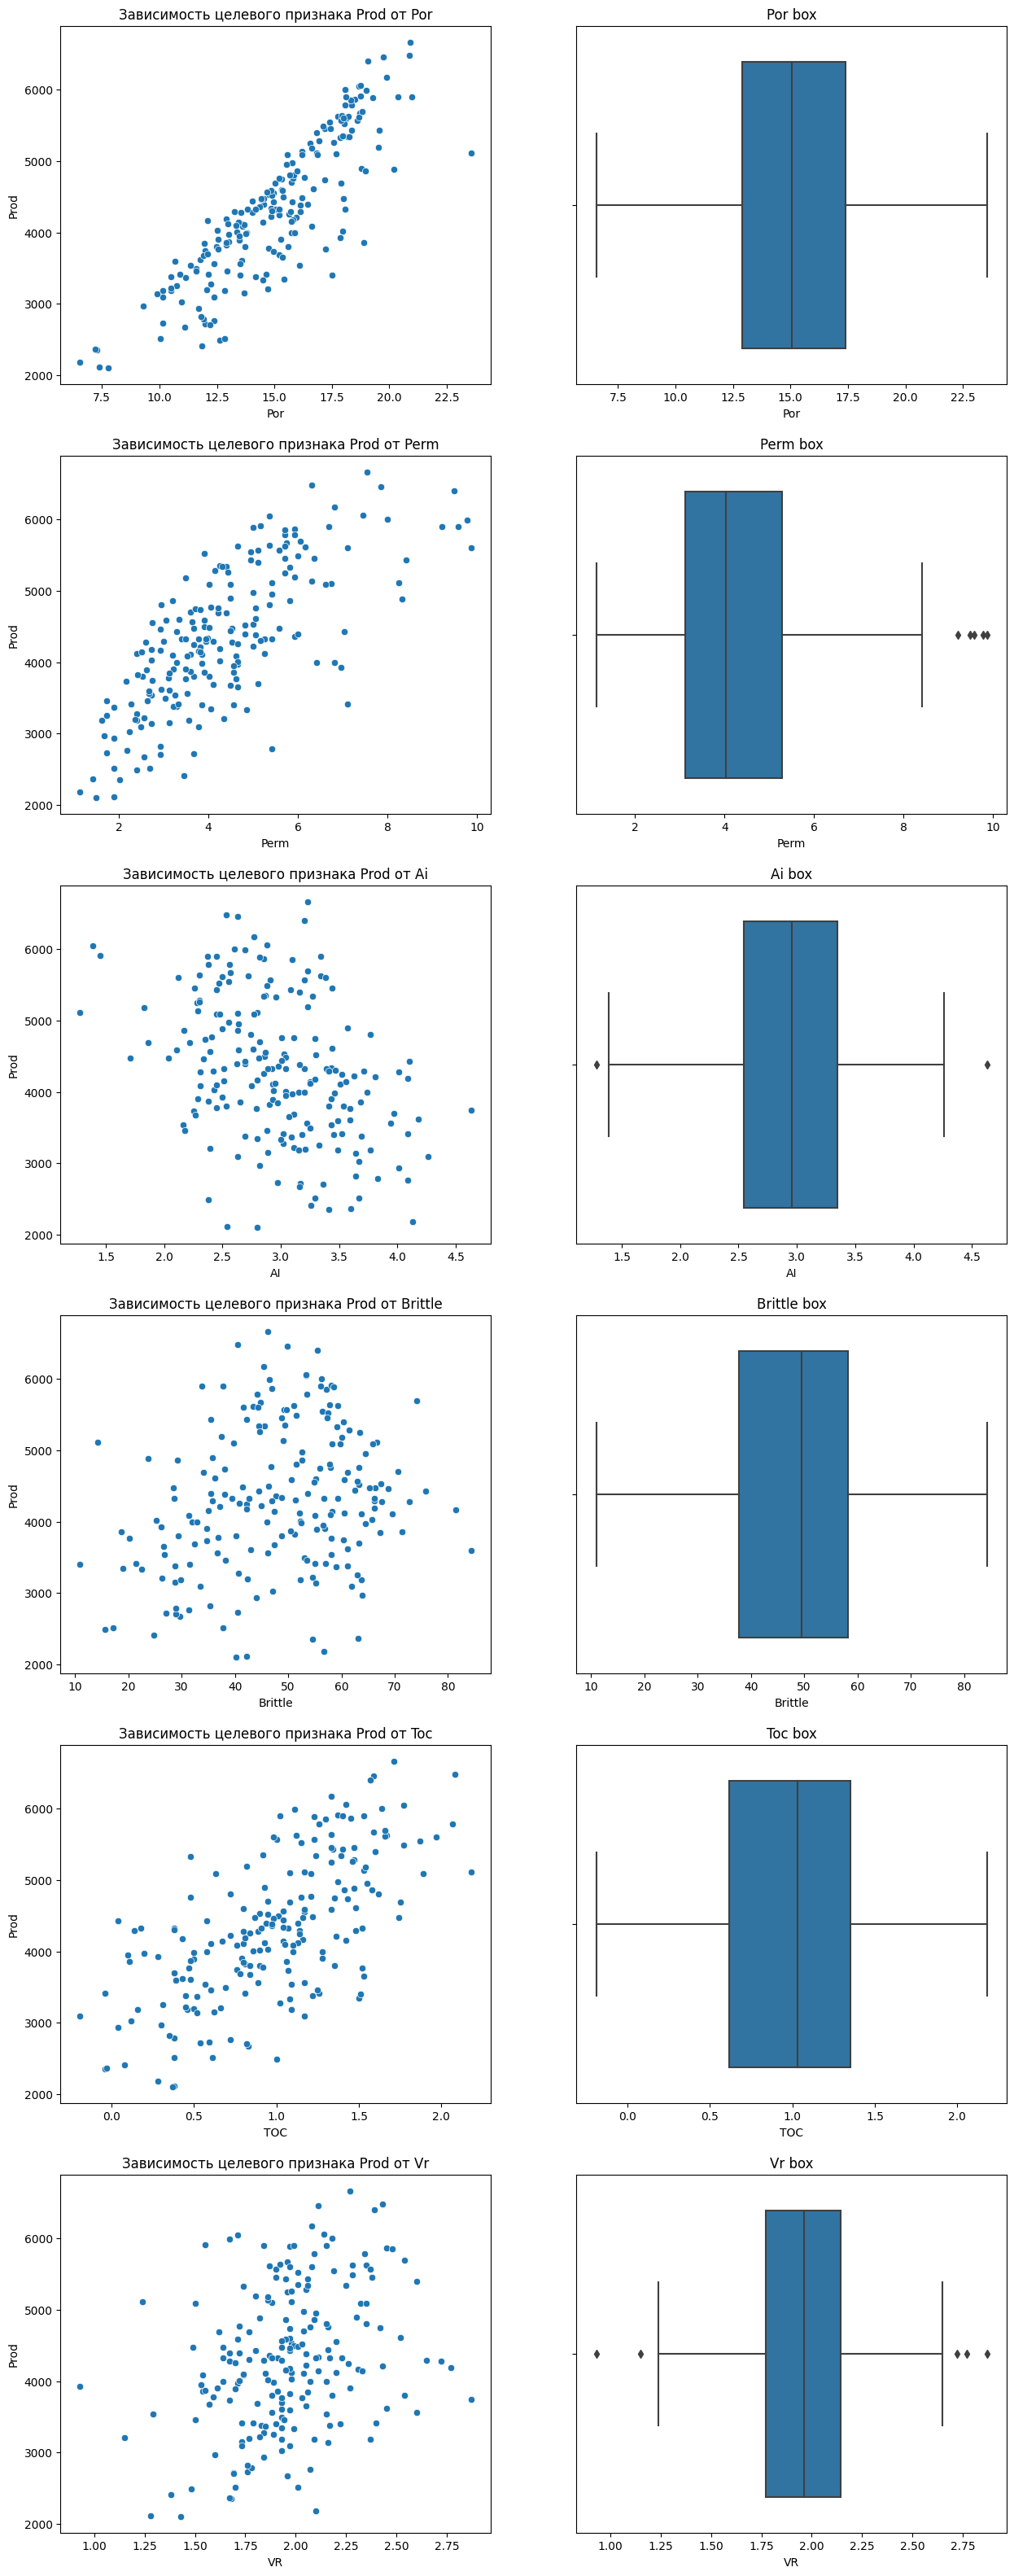

In [174]:
# Ваш код здесь
features = list(data.columns)[: -1]
fig, axes = plt.subplots(len(features), 2, figsize = (15,40))
for i, feature in enumerate(features):
    sc_pl = sns.scatterplot(x=data[feature], y=data.Prod, ax=axes[i][0])
    sc_pl.set_title(f"Зависимость целевого признака Prod от {feature.title()}")
    box_pl = sns.boxplot(data=data, x=feature, ax=axes[i][1])
    box_pl.set_title(f"{feature.title()} box")
    

По данным графикам можно сделать следующие выводы:
* Наблюдается определенная линейная зависимость между целeвым  признаком  Prod и следующими признаками Por, Perm, TOC
* С признаком Ai проглядывается обратная линейная зависимость
* С остальными признаками VR, Brittle  визуально трудно  опрделить.
* Незначительные выбросы у признаков: Perm, Ai, VR        


По зависимости признаков более точно проиллюстрирует корреляционная матрица. 

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

              Por      Perm        AI   Brittle       TOC        VR      Prod
Por      1.000000  0.760546 -0.461549 -0.218570  0.711831  0.111860  0.861910
Perm     0.760546  1.000000 -0.239636 -0.124017  0.471746  0.051023  0.727426
AI      -0.461549 -0.239636  1.000000  0.127599 -0.531864  0.499143 -0.390835
Brittle -0.218570 -0.124017  0.127599  1.000000 -0.214282  0.317929  0.237155
TOC      0.711831  0.471746 -0.531864 -0.214282  1.000000  0.299483  0.654445
VR       0.111860  0.051023  0.499143  0.317929  0.299483  1.000000  0.323182
Prod     0.861910  0.727426 -0.390835  0.237155  0.654445  0.323182  1.000000


 Ранг матрицы: 7


 Определитель матрицы: 0.0007477684988022884


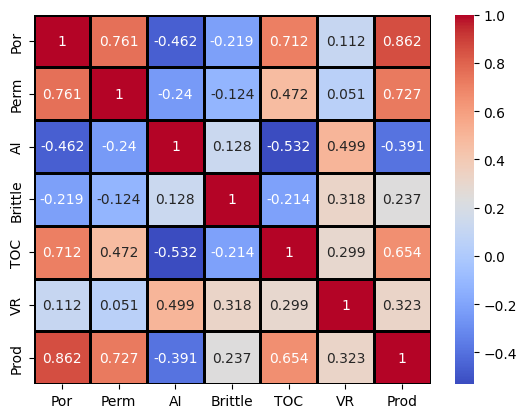

In [175]:
# Ваш код здесь
corr_mat = data.corr()
print(corr_mat)
# Визуализация корреляционной матрицы
sns.heatmap(corr_mat, annot=True, fmt='.3g', cmap= 'coolwarm', linewidths=2, linecolor='black')

print(f'\n\n Ранг матрицы: {np.linalg.matrix_rank(corr_mat)}')

print(f'\n\n Определитель матрицы: {np.linalg.det(corr_mat)}')



### Вывод:

Ранг  равен 7(что является размером данной матрицы), чистой коллинеарности  нет, но определитель всё равно маловат и состовляет 0.0007477684988022884.   
Значения коэффициентов корреляции между признаками Perm и Por , TOC и Por, а так же между целевым признаком Prod и  Perm - больше 0.7 , но меньше 0.9 гоаорит о сильной корреляции. Коэфициент мужду Prod и Por вообще равен 0.862, что при округлении до десятых, может составить 0.9 а это уже случай абсолютной связи. Хотя формально эти факторы линейно независимы. Такие корреляции ощутимо портят картину, что и отражается на определителе.

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [176]:
# Создайте матрицу наблюдений `X` и вектор правильных ответов `y`
X = data.drop('Prod', axis=1)
y = data[['Prod']]
# Формируем матрицу 'A' из столбца единиц и факторов матрицы 'X':
A = np.column_stack((np.ones(200), X))
# вычислим OLS-оценку для коэффициентов
w_hat = np.linalg.inv(A.T@A)@A.T@y

print('OLS-оценка для коэффициентов:')
for i, coef in enumerate(w_hat.values):
    print (f'w_{i} = {round(coef[0])}')
    
# стандартизируем векторы в столбцах матрицы A
A_cent = X - X.mean()
A_st = A_cent/np.linalg.norm(A_cent, axis=0)
# стандартизируем вектор целевой переменной
y_cent = y - y.mean()
y_st = y_cent/np.linalg.norm(y_cent)
# вычислим OLS-оценку для стандартизированных коэффициентов
w_hat_st=np.linalg.inv(A_st.T@A_st)@A_st.T@y_st

print('\nOLS-оценка для стандартизированных коэффициентов:')
for i, coef in enumerate(w_hat_st.values):
    print (f'w_{i+1} = {round(coef[0], 3)}')


OLS-оценка для коэффициентов:
w_0 = -1230
w_1 = 230
w_2 = 116
w_3 = -364
w_4 = 25
w_5 = -77
w_6 = 783

OLS-оценка для стандартизированных коэффициентов:
w_1 = 0.69
w_2 = 0.203
w_3 = -0.208
w_4 = 0.356
w_5 = -0.038
w_6 = 0.237


### Вывод:
Для оценки информативности и влияния признаков на таргет, вычеслили коэфициенты OLS заранее привидя данные к одному маштабу(стандартизировали). По полученным результаттам получаем , что наибольшее влияния на объем оказывают данные признака 'Por' наименнее влияет признак 'TOC'. Еще можно подметить,  что при  увилечении значений столбцов 'Por', 'Perm', 'Brittle' и 'VR' целевой признак увеличивается т.е. прямая зависимость. При увилечении значений признаков 'AI', 'TOC' целевой признак уменьшается(обратная зависимость)


### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [177]:
# Ваш код здесь
new = {
    'Por': [15.32],
    'Perm': [3.71],
    'AI': [3.29],
    'Brittle': [55.99],
    'TOC': [1.35],
    'VR': [2.42]
 }
new_data = pd.DataFrame(new)

# Произведем прогноз с помощью полученной модели, с входными данными, которые представлены в переменной new
new=np.column_stack((np.ones(1), new_data))
print('prediction:', (new@w_hat).values)

# Произведем прогноз для всех скважин из обучающего набора данных.

y_pred = A @ w_hat
y_pred

#Рассчитываем MAE
print('MAE score: {:.3f} млн. кубических футов'.format(metrics.mean_absolute_error(y, y_pred)))

#Рассчитываем MAPE
print('MAPE score: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y, y_pred) * 100))

#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_pred)))

prediction: [[4722.7215383]]
MAE score: 153.604 млн. кубических футов
MAPE score: 3.629 %
R2 score: 0.960


### Вывод:
Сделав прогноз выработки газа для скважины с полученными параметрами, получился следующий результат `4722.7215383`. Разница от  реального результата, который состовляет `4748.315024` миллионов кубических футов газа в день, равняется `25.5934857`. Что  можно охарактеризовать, как вполне приемлимым, учитывая что данная разница меньше значении метрики МАЕ(вычеслена по всей обучающей выборки).    
 Значение МАЕ состовляет 153.604. Также был рачитана метрика МАРЕ = 3,629 %. Т.к. МАЕ не было озвучена заказчикам, считаю что модель справилась неплохо. Конечно нужно учитывать, что расчет метрик происходил по данным, с помощью которых происходила построение модели. Более объективные оценки метрик можно получить, если их расчитать на данных которые не брали для расчета OLS т.е. тестовых.

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).


OLS-оценка для стандартизированных коэффициентов:
w_1 = Por   = 0.69
w_2 = Perm   = 0.203
w_3 = AI   = -0.208
w_4 = Brittle   = 0.356
w_5 = TOC   = -0.038
w_6 = VR   = 0.237


<Axes: >

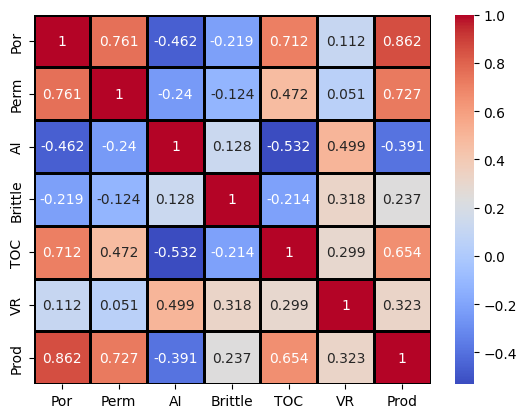

In [178]:
# Ваш код здесь
print('\nOLS-оценка для стандартизированных коэффициентов:')
for i, coef in enumerate(w_hat_st.values):
    print (f'w_{i+1} = {corr_mat.index[i]}   = {round(coef[0], 3)}')
    
sns.heatmap(corr_mat, annot=True, fmt='.3g', cmap= 'coolwarm', linewidths=2, linecolor='black')

### Вывод:
В нашей модели есть фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции - 'ТОС'. Можно предположить что это обусловленно слишком маленьким значением определителя, который практически  равен нулю, а это следствие слишком больших значение корреляционной матрицы у некоторых признаков. Что можно говорить о сильной корреляции.

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [179]:
# Ваш код здесь
X_sel = data[['Por', 'AI', 'Brittle', 'VR']]
# Формируем матрицу 'A_sel' из столбца единиц и факторов матрицы 'X_sel':
A_sel = np.column_stack((np.ones(200), X_sel))
# вычислим OLS-оценку для коэффициентов
w_hat_sel = np.linalg.inv(A_sel.T@A_sel)@A_sel.T@y

print('OLS-оценка по всем признакам для коэффициентов :')
for i, coef in enumerate(w_hat.values):
    if i == 0:
        print (f'w_{i} = {round(coef[0])}')
    else:
        print (f'w_{i} = {corr_mat.index[i - 1]} = {round(coef[0])}')
        
        
    
print('\nOLS-оценка по выбранным признакам для коэффициентов:')
for i, coef in enumerate(w_hat_sel.values):
    if i == 0:
        print (f'w_{i} = {round(coef[0])}')
    else:
        print (f'w_{i} = {X_sel.columns[i - 1]} = {round(coef[0])}')

# Произведем прогноз для всех скважин из обучающего набора данных.

y_pred = A_sel @ w_hat_sel
y_pred

#Рассчитываем MAE
print('\nMAE score: {:.3f} млн. кубических футов'.format(metrics.mean_absolute_error(y, y_pred)))

#Рассчитываем MAPE
print('MAPE score: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y, y_pred) * 100))   

#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_pred))) 

OLS-оценка по всем признакам для коэффициентов :
w_0 = -1230
w_1 = Por = 230
w_2 = Perm = 116
w_3 = AI = -364
w_4 = Brittle = 25
w_5 = TOC = -77
w_6 = VR = 783

OLS-оценка по выбранным признакам для коэффициентов:
w_0 = -1835
w_1 = Por = 293
w_2 = AI = -200
w_3 = Brittle = 28
w_4 = VR = 517

MAE score: 171.431 млн. кубических футов
MAPE score: 4.044 %
R2 score: 0.945


### Вывод:
Значения коэфициентов по признакам изменилось. Значения w0, Brittle, AI, увеличились. VR - уменьшились. Значения метрик МАЕ, МАРЕ, R2. незначительно ухудшились. Судить по данным метрикам о том какая модель лучше некорректно, т.к. они расчитывались  на обучающих данных.

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [180]:
# Ваш код здесь
lr = linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
lr.fit(X_sel, y)

print('w0: {}'.format(round(lr.intercept_[0])))
for i in range(len(lr.coef_[0])):
    print('w{}: {}'.format(i + 1, round(lr.coef_[0][i])))


y_predict = lr.predict(X_sel)   

#Рассчитываем MAE
print('\nMAE score: {:.3f} млн. кубических футов'.format(metrics.mean_absolute_error(y, y_pred)))

#Рассчитываем MAPE
print('MAPE score: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y, y_pred) * 100))   

#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_pred)))  


w0: -1835
w1: 293
w2: -200
w3: 28
w4: 517

MAE score: 171.431 млн. кубических футов
MAPE score: 4.044 %
R2 score: 0.945


### Вывод:
Результаты коэфифиентов модели и метрик  полученные  по методу наименьших квадратов  используя матричную формулу и библиотеку numpy с одной стороны и воспользуясь классом `LinearRegression` из библиотеки `sklearn` получились одинакове. Что можно утверждать о использовании обоих методик. В пользу класса `LinearRegression` из библиотеки `sklearn` можно сказать о менее коротком программном коде.  

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [181]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [182]:
# Ваш код здесь
hyperparameters = [] # список для гиперпараметров
polynomial_features = [] # Список использовались ли полиномиальные признаки при построении модели
MAPE_tren = [] # Список значений выбранной метрики на тренировочных фолдах при кросс-валидации модели
MAPE_valid = [] # Список значений выбранной метрики на валидационных фолдах при кросс-валидации модели

X = data[['Por', 'AI', 'Brittle', 'VR']]
y = data[['Prod']]

# инициализируем стандартизатор StandardScaler
scaler = StandardScaler()

# подгоняем параметры стандартизатора (вычисляем среднее и СКО)
X_sc = scaler.fit_transform(X)
# добавляем полиномиальные признаки

poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_sc)

print(f'Количество факторов после генерации полиномиальных признаков: {X_poly.shape[1]}\n')

# создаём модель линейной регрессии
lr = LinearRegression()

# оцениваем качество модели на кросс-валидации, метрика — MAPE
cv_results = cross_validate(lr, X_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)

print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))

hyperparameters.append(' ') 
polynomial_features.append('Да') 
MAPE_tren.append(round(-cv_results['train_score'].mean()* 100, 3)) 
MAPE_valid.append(round(-cv_results['test_score'].mean() * 100, 3))

Количество факторов после генерации полиномиальных признаков: 34

MAPE на тренировочных фолдах: 1.77 %
MAPE на валидационных фолдах: 2.68 %


### Выводы
После генерации признаков третьего порядка, их количество увеличилось до 34.   
Модель была у нас линейная регрессия. Оценивали качество на кросс-валидации, метрика — MAPE.  
Результаты метрики получили следующие на тренировочных фолдах: 1.77 %, на валидационных фолдах: 2.68 %.    
Не смотря на то, что  по   факту значения относительно небольшие, разница между оценками тренировачной и валидационной состовляет 34%, а это довольно таки много. Поэтому можно говорить о переобучении.

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [183]:
# Ваш код здесь
# Подбор гиперпараметров с помощью перекрестной проверки
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso = Lasso()
grid_search = GridSearchCV(lasso, param_grid, cv=5)
grid_search.fit(X_poly, y)

# Вывод наилучшего значения alpha
print("Наилучшее значение alpha:", grid_search.best_params_['alpha'])

# создаём модель линейной регрессии c L1-регуляризацией c коэффициентом регуляризации alpha=10, который получили ранее
lasso = Lasso(alpha=10, max_iter=10000)

# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(lasso, X_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('\nMAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))

hyperparameters.append('alpha = ' + str (grid_search.best_params_['alpha']))
polynomial_features.append('Да') 
MAPE_tren.append(round(-cv_results['train_score'].mean()* 100, 3)) 
MAPE_valid.append(round(-cv_results['test_score'].mean() * 100, 3))

Наилучшее значение alpha: 10

MAPE на тренировочных фолдах: 1.95 %
MAPE на валидационных фолдах: 2.38 %


### Выводы
Модель линейная регрессия c L1-регуляризацией c коэффициентом регуляризации `alpha`=10.   
Значение оптимального `alpha` получили при использовании  метода перекрестной проверки (Cross-Validation).  
Результаты метрики получили следующие на тренировочных фолдах: 1.95 %, на валидационных фолдах: 2.38 %.  
Результат метрики на тренировочных фолдах немного ухудшился по сравнению с моделью линпейной регрессии, но на валидационных улучшился. За счет этого разница значительно уменьшилось и состовляет 18%. Это уже неплохо, но еще многовато.
  


### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [184]:
# Ваш код здесь
# Подбор гиперпараметров с помощью перекрестной проверки
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, cv=5)
grid_search.fit(X_poly, y)

# Вывод наилучшего значения alpha
print("Наилучшее значение alpha:", grid_search.best_params_['alpha'])

# создаём модель линейной регрессии c L2-регуляризацией c коэффициентом регуляризации alpha=1, который получили ранее
ridge = Ridge(alpha=1, solver='svd')
# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(ridge, X_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))

hyperparameters.append('alpha = ' + str (grid_search.best_params_['alpha']))
polynomial_features.append('Да') 
MAPE_tren.append(round(-cv_results['train_score'].mean()* 100, 3)) 
MAPE_valid.append(round(-cv_results['test_score'].mean() * 100, 3))


Наилучшее значение alpha: 1
MAPE на тренировочных фолдах: 1.83 %
MAPE на валидационных фолдах: 2.72 %


### Выводы
Модель линейная регрессия c L2-регуляризацией c коэффициентом регуляризации `alpha`=1.   
Значение оптимального `alpha` получили при использовании  метода перекрестной проверки (Cross-Validation).  
Результаты метрики получили следующие на тренировочных фолдах: 1.83 %, на валидационных фолдах: 2.72%.  
Результат получился на уровне, когда мы использовали простую линейную регрессию без регуляризации. Разница междц метриками тренировачной и валидационной состовляет 33%. Данная модель справилась хуже, чем модель L1-регуляризацией. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [185]:
# Ваш код здесь
# Подбор гиперпараметров с помощью перекрестной проверки
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
elasticnet = ElasticNet()
grid_search = GridSearchCV(elasticnet, param_grid, cv=5)
grid_search.fit(X_poly, y)

# Вывод наилучших значений alpha и l1_ratio
print("Наилучшее значение alpha:", grid_search.best_params_['alpha'])
print("Наилучшее значение l1_ratio:", grid_search.best_params_['l1_ratio'])

# создаём модель линейной регрессии c L1- и L2-регуляризациями
elastic = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000)
# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(elastic, X_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('\nMAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))

hyperparameters.append('alpha = ' + str (grid_search.best_params_['alpha']) + ', l1_ratio = ' + str(grid_search.best_params_['l1_ratio'])) 
polynomial_features.append('Да') 
MAPE_tren.append(round(-cv_results['train_score'].mean()* 100, 3)) 
MAPE_valid.append(round(-cv_results['test_score'].mean() * 100, 3))

Наилучшее значение alpha: 0.01
Наилучшее значение l1_ratio: 0.5

MAPE на тренировочных фолдах: 1.81 %
MAPE на валидационных фолдах: 2.70 %


Модель линейная регрессия с L1- и L2-регуляризациями c коэффициентом регуляризации `alpha`= 0.01 и `l1_ratio` =  0.5.   
Значение оптимальноых гиперпараметров получили при использовании  метода перекрестной проверки (Cross-Validation).  
Результаты метрики получили следующие на тренировочных фолдах: 1.81 %, на валидационных фолдах: 2.70%.  
Результат получился на уровне, когда мы использовали простую линейную регрессию без регуляризации и с L2 - регуляризацией. Разница междц метриками тренировачной и валидационной состовляет 33%. Данная модель справилась хуже, чем модель L1-регуляризацией.

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [186]:
# Ваш код здесь
dictionary = {
    'Модель': ['LinearRegression', 'Lasso', 'Ridge', 'ElasticNet'],
    'Гиперпараметры': hyperparameters,
    'Полиномиальные признаки': polynomial_features,
    'MAPE_tren': MAPE_tren,
    'MAPE_valid': MAPE_valid       
}
df_results = pd.DataFrame(dictionary)
df_results



,Модель,Гиперпараметры,Полиномиальные признаки,MAPE_tren,MAPE_valid
0,LinearRegression,,Да,1.773,2.681
1,Lasso,alpha = 10,Да,1.951,2.376
2,Ridge,alpha = 1,Да,1.826,2.717
3,ElasticNet,"alpha = 0.01, l1_ratio = 0.5",Да,1.810,2.701


По данной таблице можно сделать следующи выводы:
 * Лучшую метрику на валидационных фолдах показала линейной регрессией с L1 - регуляризацией(LASSO)
 * Худшую метрику на валидационных фолдах показала линейной регрессией c L2 - регуляризацией(RIDGE). Хотя утверждать, что данная модель сильно провалилась в корне неправильно. Модели линейной регрессиии и регрессии с L1- и L2-регуляризациями, показали примерно такой же результат.
 * Во всех моделях представленных в таблице использовались полинаминальные признаки, за счет этого удалось значительно улучшить метрику посравнению с значениями метрик, где мы использовали обычные признаки (первый блок нашего блокнота).
 * Менее переобученной моделью является Lasso.